### Import libraries

In [1]:
# import statements
%load_ext autoreload
%autoreload 2
%cd "../"

import torch 
from torch.autograd import Variable 
import torch.nn as nn
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    

import numpy as np
import time

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import pickle
from scipy.cluster.vq import kmeans2
import scipy.stats as ss
from scipy.io import loadmat

/m/home/home5/56/kapoorj1/unix/repos/bayesian-ode


### Generate data

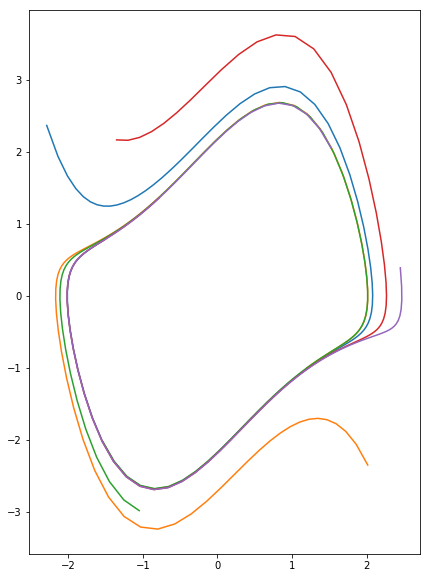

In [2]:
# generate data
use_gpu = 1

class VDP(torch.nn.Module):
    def forward(self, t, x):
        return torch.cat([x[:,1:2], (1-x[:,0:1]**2)*x[:,1:2]-x[:,0:1]],1)

# from torchdiffeq import odeint_adjoint as odeint
from torchdiffeq import odeint

device = torch.device('cuda:' + str(use_gpu) if torch.cuda.is_available() else 'cpu')

N = 5
R = 3

x0 = torch.from_numpy(2*R*ss.uniform.rvs(size=[N,2])-R)
t = torch.linspace(0., 7., 100)

with torch.no_grad():
    X = odeint(VDP(), x0, t, method='rk4').numpy()
    X = np.transpose(X,[1,0,2])
    Y = X + ss.norm.rvs(size=X.shape)*0.1
    
plt.figure(1,[7,10])
for i in range(X.shape[0]):
    plt.plot(X[i,:,0],X[i,:,1],'-')

## Implementation-1, gradients computed via sensitivities (uses autograd as a subroutine) 

### Initialize the model, parameters, variables, etc

In [21]:
# create variables, functions etc
M   = 6 # MxM inducing grid
D   = 2
sf  = 1
ell = 0.75

torch.set_default_tensor_type(torch.DoubleTensor)
xv = np.linspace(np.min([np.min(Y_[:,0]) for Y_ in Y]), np.max([np.max(Y_[:,0]) for Y_ in Y]), M)
yv = np.linspace(np.min([np.min(Y_[:,1]) for Y_ in Y]), np.max([np.max(Y_[:,1]) for Y_ in Y]), M)
xv,yv = np.meshgrid(xv,yv)
Z  = np.array([xv.T.flatten(),yv.T.flatten()]).T
Zt = torch.from_numpy(Z)
Yt = torch.from_numpy(Y)
U0 = 0.1*torch.randn(M*M, D)
# U0 = VDP().forward(0,Zt)

def _flatten(sequence):
    flat = [p.contiguous().view(-1) for p in sequence]
    return torch.cat(flat) if len(flat) > 0 else torch.tensor([])

def sq_dist(X1,X2):
    X1 = X1 / ell
    X1s = torch.sum(X1**2, dim=1).view([-1,1]) 
    X2 = X2 / ell
    X2s = torch.sum(X2**2, dim=1).view([1,-1])
    return -2*torch.mm(X1,torch.t(X2)) + X1s + X2s

def K(X1,X2):
    dist = sq_dist(X1,X2)
    return sf**2 * torch.exp(-dist / 2)

# gradient matching
F_ = (Yt[:,1:,:]-Yt[:,:-1,:]) / (t[1]-t[0])
F_ = F_.contiguous().view(-1,D)
Z_ = Yt[:,:-1,:].contiguous().view(-1,D)
Kxz = K(Zt,Z_)
Kzzinv = (K(Z_,Z_)+0.2*torch.eye(Z_.shape[0])).inverse()
U0 = torch.mm(torch.mm(Kxz,Kzzinv),F_) # not whitened
Linv = torch.cholesky(K(Zt,Zt)).inverse()
U0 = torch.mm(Linv,U0) # whitened

class KernelRegression(torch.nn.Module):
    def __init__(self):
        super(KernelRegression, self).__init__()
        self.U = torch.nn.Parameter(U0, requires_grad=True)
        self.Z = Zt
        self.Kzz = K(Zt,Zt)
        self.Kzzinv = self.Kzz.inverse()
        self.L = torch.cholesky(self.Kzz)
        self.KzzinvL = torch.mm(self.Kzzinv,self.L)

    def forward(self, t, X):
        T = torch.mm(K(X,self.Z),self.KzzinvL)
        return torch.mm(T,self.U)

class ODEINT_FS(torch.autograd.Function):
    @staticmethod
    def forward(ctx, func, x0, t, th):
        xode = odeint(func, x0, t, method='rk4').permute([1,0,2])
        ctx.func = func
        ctx.save_for_backward(x0,t,th,xode)
        return xode # N,T,D
    @staticmethod
    def backward(ctx, *grad_output): # grad_output[0] N,T,D ---> dL/dxode
        # print('backward')
        func = ctx.func
        x0,t,th,xode = ctx.saved_tensors
        N = x0.shape[0]  # problem dimensionality
        D = x0.shape[1]  # problem dimensionality
        MD = torch.numel(th) # number of parameters in the differential function
        with torch.no_grad():
            def ode_sens_rhs(t,xS): # xS = N,D,(1+MD)
                x = xS[:,:,0].view(-1,D) # N,D
                S = xS[:,:,1:] # N,D,MD
                th = list(func.parameters())[0]
                dxs = []
                dSs = []
                for j in range(N):
                    x_ = x[j:j+1].requires_grad_(True) #.detach() # 1,D
                    S_ = S[j] # D,MD
                    J = [] # accumulate columns of J here
                    R = [] # accumulate columns of R here
                    for i in range(D): # partial derivative of output dimension i 
                        with torch.set_grad_enabled(True):
                            f = func(t,x_)[0,i]
                            dfdxth = torch.autograd.grad(f, [x_,th], allow_unused=False, retain_graph=False)
                            J.append(dfdxth[0])
                            R.append(dfdxth[1].view(1,-1)) # 1,MD
                    J = torch.cat(J) # D,D
                    R = torch.cat(R) # D,MD
                    dS = torch.matmul(J,S_)+R # D,MD
                    dx = func(t,x_) # 1,D
                    dxs.append(dx.unsqueeze(2)) # 1,D,1
                    dSs.append(dS.unsqueeze(0)) # 1,D,MD
                dx = torch.cat(dxs) # N,D,1
                dS = torch.cat(dSs) # N,D,MD
                dxdS = torch.cat([dx,dS],2)
                return dxdS
            x0 = torch.unsqueeze(x0,2) # N,D,1
            S0 = torch.zeros(N,D,MD)
            xS0 = torch.cat((x0,S0),2) # N,D,(1+MD)
            xS = odeint(ode_sens_rhs, xS0, t, method='rk4') # T,N,D,(1+MD)
            xode2 = xS[:,:,:,0].permute([1,0,2]) # N,T,D
            # print('error between two ode integrations is {:f}'.format(torch.abs(xode-xode2).sum().numpy()))
            S = xS[:,:,:,1:].permute([1,2,0,3]) # N,D,T,MD
            # print(grad_output[0].shape) # N,T,D
            dlossdx = grad_output[0].permute([0,2,1]).unsqueeze(3) # N,D,T,1
            dlossdU = torch.sum(S*dlossdx,[0,1,2]) # MD
        return None,None,None,dlossdU # N,T,D
    
odeint_fs = ODEINT_FS.apply
kreg = KernelRegression()

# check why doesn't work
# from torch.autograd import gradcheck
# th_ = _flatten(kreg.parameters())
# test = gradcheck(odeint_fs, [kreg,x0,t,th_], eps=1e-6, atol=1e-4)
# print(test)

def odeint_forw_sens(func, x0, t):
    th = _flatten(func.parameters())
    xode = odeint_fs(kreg, x0, t, th)
    return xode
    

### Optimize

In [ ]:
# optimization

logsn = torch.nn.Parameter(torch.zeros(2), requires_grad=True)
params = [kreg.U,logsn]
optimizer = optim.Adam(params, lr=5e-3)

    
for itr in range(500):
    optimizer.zero_grad()
    T   = min(3+itr//10, len(t))
    t_  = t[:T]
    Yt_ = Yt[:,:T,:]
    xode = odeint_forw_sens(kreg,x0,t_)
    loss = torch.sum((Yt_-xode)**2 / torch.exp(logsn)**2) +  torch.numel(Yt_)*torch.sum(logsn)/D + \
        torch.sum(torch.diag(torch.mm(kreg.U.t(),kreg.U)))/2
    loss.backward()
    optimizer.step()

    if itr % 1 == 0:
        with torch.no_grad():
            xode = odeint_forw_sens(kreg,x0,t)
            loss = torch.sum((Yt-xode)**2 / torch.exp(logsn)**2) +  torch.numel(Yt)*torch.sum(logsn)/D
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))

    # break
    end = time.time()


### Visualize

In [ ]:
# plotting
xode = odeint_forw_sens(kreg, x0, t).detach().numpy()
U = kreg.U.detach().numpy()
Z = Zt.detach().numpy()

cols = ['r','b','g','m','c','k']
plt.figure(1,[7,10])
plt.scatter(Z[:,0],Z[:,1],100, facecolors='none', edgecolors='k')
plt.quiver(Z[:,0],Z[:,1],U[:,0],U[:,1],units='height',width=0.006,color='k')
for i in range(min(6,xode.shape[0])):
    plt.plot(X[i,:,0],X[i,:,1],'o',color=cols[i])
    plt.plot(xode[i,:,0],xode[i,:,1],'-',color=cols[i])

## Implementation-2 that uses Torch autograd, no sensitivities/adjoints 

### Initialize the model, parameters, variables, etc

In [32]:
# create variables, functions etc
M   = 6 # MxM inducing grid
D   = 2
sf  = 1
ell = 0.75

torch.set_default_tensor_type(torch.DoubleTensor)
xv = np.linspace(np.min([np.min(Y_[:,0]) for Y_ in Y]), np.max([np.max(Y_[:,0]) for Y_ in Y]), M)
yv = np.linspace(np.min([np.min(Y_[:,1]) for Y_ in Y]), np.max([np.max(Y_[:,1]) for Y_ in Y]), M)
xv,yv = np.meshgrid(xv,yv)
Z  = np.array([xv.T.flatten(),yv.T.flatten()]).T
Zt = torch.from_numpy(Z)
Xt = torch.from_numpy(X)
U0 = 0.1*torch.randn(M*M, D)
# U0 = VDP().forward(0,Zt)

def sq_dist(X1,X2):
    X1 = X1 / ell
    X1s = torch.sum(X1**2, dim=1).view([-1,1]) 
    X2 = X2 / ell
    X2s = torch.sum(X2**2, dim=1).view([1,-1])
    return -2*torch.mm(X1,torch.t(X2)) + X1s + X2s

def K(X1,X2):
    dist = sq_dist(X1,X2)
    return sf**2 * torch.exp(-dist / 2)

# gradient matching
F_ = (Xt[:,1:,:]-Xt[:,:-1,:]) / (t[1]-t[0])
F_ = F_.contiguous().view(-1,D)
Z_ = Xt[:,:-1,:].contiguous().view(-1,D)
Kxz = K(Zt,Z_)
Kzzinv = (K(Z_,Z_)+0.2*torch.eye(Z_.shape[0])).inverse()
U0 = torch.mm(torch.mm(Kxz,Kzzinv),F_)


class KernelRegression(torch.nn.Module):
    def __init__(self):
        super(KernelRegression, self).__init__()
        self.U = torch.nn.Parameter(U0, requires_grad=True)
        self.logsn = torch.nn.Parameter(torch.zeros(2), requires_grad=True)
        self.Z = Zt

    def forward(self, t, X):
#         Z = self.Z
#         M = Z.shape[0]
#         N = X.shape[0]
#         A_LU = torch.lu(K(Z,Z).view(-1,M,M)) # 1,M,M
#         Kxz  = torch.t(K(X,Z)).view(-1,M,N)  # 1,M,N
#         A = torch.lu_solve(Kxz, *A_LU).view(M,N) # M x N
#         f = torch.mm(torch.t(A),self.U) # N x M
#         return f
#         Z = self.Z
#         Ltinv = torch.t(torch.cholesky(K(Z,Z))).inverse()
#         return torch.mm(torch.mm(K(X,Z),Ltinv),self.U)
        Z = self.Z
        Kzzinv = K(Z,Z).inverse()
        return torch.mm(torch.mm(K(X,Z),Kzzinv),self.U)

npode = KernelRegression()
lbfgs = optim.LBFGS(npode.parameters(), lr=1e-3)
# optimizer = optim.Adam(npode.parameters(), lr=5e-3)
optimizer = optim.SGD(npode.parameters(), lr=1e-5)


### Optimize

In [33]:
# optimization
def closure():
    optimizer.zero_grad()
    xode = odeint(npode, x0, t).permute([1,0,2])
    loss = torch.mean((Xt-xode)**2 / torch.exp(npode.logsn))
    loss.backward()
    return loss
    
for itr in range(1000):
    optimizer.zero_grad()
    xode = odeint(npode, x0, t, method='rk4').permute([1,0,2])
    loss = torch.sum((Xt-xode)**2 / torch.exp(npode.logsn)**2) +  torch.numel(Xt)*torch.sum(npode.logsn)/D + \
        torch.sum(torch.diag(torch.mm(npode.U.t(),npode.U)))/2
    loss.backward()
    optimizer.step()
#     lbfgs.step(closure)

    if itr % 1 == 0:
        with torch.no_grad():
            xode = odeint(npode, x0, t, method='rk4').permute([1,0,2])
            loss = torch.mean((Xt-xode)**2 / torch.exp(npode.logsn))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))

    end = time.time()

Iter 0000 | Total Loss 0.450096
Iter 0001 | Total Loss 0.441300
Iter 0002 | Total Loss 0.432583
Iter 0003 | Total Loss 0.423944
Iter 0004 | Total Loss 0.415386
Iter 0005 | Total Loss 0.406909
Iter 0006 | Total Loss 0.398513
Iter 0007 | Total Loss 0.390201
Iter 0008 | Total Loss 0.381972
Iter 0009 | Total Loss 0.373829
Iter 0010 | Total Loss 0.365772
Iter 0011 | Total Loss 0.357803
Iter 0012 | Total Loss 0.349923
Iter 0013 | Total Loss 0.342134
Iter 0014 | Total Loss 0.334436
Iter 0015 | Total Loss 0.326831
Iter 0016 | Total Loss 0.319320
Iter 0017 | Total Loss 0.311905
Iter 0018 | Total Loss 0.304587
Iter 0019 | Total Loss 0.297368
Iter 0020 | Total Loss 0.290249
Iter 0021 | Total Loss 0.283232
Iter 0022 | Total Loss 0.276317
Iter 0023 | Total Loss 0.269506
Iter 0024 | Total Loss 0.262801
Iter 0025 | Total Loss 0.256203
Iter 0026 | Total Loss 0.249713
Iter 0027 | Total Loss 0.243333
Iter 0028 | Total Loss 0.237063
Iter 0029 | Total Loss 0.230906
Iter 0030 | Total Loss 0.224863
Iter 003

Iter 0257 | Total Loss 0.049909
Iter 0258 | Total Loss 0.049890
Iter 0259 | Total Loss 0.049871
Iter 0260 | Total Loss 0.049852
Iter 0261 | Total Loss 0.049833
Iter 0262 | Total Loss 0.049815
Iter 0263 | Total Loss 0.049796
Iter 0264 | Total Loss 0.049778
Iter 0265 | Total Loss 0.049760
Iter 0266 | Total Loss 0.049742
Iter 0267 | Total Loss 0.049724
Iter 0268 | Total Loss 0.049706
Iter 0269 | Total Loss 0.049688
Iter 0270 | Total Loss 0.049671
Iter 0271 | Total Loss 0.049653
Iter 0272 | Total Loss 0.049636
Iter 0273 | Total Loss 0.049619
Iter 0274 | Total Loss 0.049601
Iter 0275 | Total Loss 0.049584
Iter 0276 | Total Loss 0.049568
Iter 0277 | Total Loss 0.049551
Iter 0278 | Total Loss 0.049534
Iter 0279 | Total Loss 0.049518
Iter 0280 | Total Loss 0.049501
Iter 0281 | Total Loss 0.049485
Iter 0282 | Total Loss 0.049469
Iter 0283 | Total Loss 0.049453
Iter 0284 | Total Loss 0.049437
Iter 0285 | Total Loss 0.049421
Iter 0286 | Total Loss 0.049405
Iter 0287 | Total Loss 0.049390
Iter 028

Iter 0515 | Total Loss 0.048839
Iter 0516 | Total Loss 0.048848
Iter 0517 | Total Loss 0.048856
Iter 0518 | Total Loss 0.048864
Iter 0519 | Total Loss 0.048873
Iter 0520 | Total Loss 0.048882
Iter 0521 | Total Loss 0.048890
Iter 0522 | Total Loss 0.048899
Iter 0523 | Total Loss 0.048908
Iter 0524 | Total Loss 0.048917
Iter 0525 | Total Loss 0.048926
Iter 0526 | Total Loss 0.048935
Iter 0527 | Total Loss 0.048944
Iter 0528 | Total Loss 0.048953
Iter 0529 | Total Loss 0.048962
Iter 0530 | Total Loss 0.048971
Iter 0531 | Total Loss 0.048980
Iter 0532 | Total Loss 0.048990
Iter 0533 | Total Loss 0.048999
Iter 0534 | Total Loss 0.049009
Iter 0535 | Total Loss 0.049018
Iter 0536 | Total Loss 0.049028
Iter 0537 | Total Loss 0.049037
Iter 0538 | Total Loss 0.049047
Iter 0539 | Total Loss 0.049057
Iter 0540 | Total Loss 0.049067
Iter 0541 | Total Loss 0.049076
Iter 0542 | Total Loss 0.049086
Iter 0543 | Total Loss 0.049096
Iter 0544 | Total Loss 0.049106
Iter 0545 | Total Loss 0.049116
Iter 054

Iter 0773 | Total Loss 0.051972
Iter 0774 | Total Loss 0.051984
Iter 0775 | Total Loss 0.051996
Iter 0776 | Total Loss 0.052008
Iter 0777 | Total Loss 0.052020
Iter 0778 | Total Loss 0.052032
Iter 0779 | Total Loss 0.052044
Iter 0780 | Total Loss 0.052056
Iter 0781 | Total Loss 0.052067
Iter 0782 | Total Loss 0.052079
Iter 0783 | Total Loss 0.052091
Iter 0784 | Total Loss 0.052103
Iter 0785 | Total Loss 0.052115
Iter 0786 | Total Loss 0.052126
Iter 0787 | Total Loss 0.052138
Iter 0788 | Total Loss 0.052150
Iter 0789 | Total Loss 0.052162
Iter 0790 | Total Loss 0.052173
Iter 0791 | Total Loss 0.052185
Iter 0792 | Total Loss 0.052196
Iter 0793 | Total Loss 0.052208
Iter 0794 | Total Loss 0.052220
Iter 0795 | Total Loss 0.052231
Iter 0796 | Total Loss 0.052243
Iter 0797 | Total Loss 0.052254
Iter 0798 | Total Loss 0.052265
Iter 0799 | Total Loss 0.052277
Iter 0800 | Total Loss 0.052288
Iter 0801 | Total Loss 0.052299
Iter 0802 | Total Loss 0.052311
Iter 0803 | Total Loss 0.052322
Iter 080

### Visualize

In [ ]:
# plotting
xode = odeint(npode, x0, t).detach().numpy()
U = npode.U.detach().numpy()
Z = npode.Z.detach().numpy()
xode = np.transpose(xode,[1,0,2])

cols = ['r','b','g','m','c','k']
plt.figure(1,[7,10])
plt.scatter(Z[:,0],Z[:,1],100, facecolors='none', edgecolors='k')
plt.quiver(Z[:,0],Z[:,1],U[:,0],U[:,1],units='height',width=0.006,color='k')
for i in range(min(6,xode.shape[0])):
    plt.plot(X[i,:,0],X[i,:,1],'o',color=cols[i])
    plt.plot(xode[i,:,0],xode[i,:,1],'-',color=cols[i])

## Old stuff

In [ ]:
# working
M   = 6 # MxM inducing grid
D   = 2
sf  = 1
ell = 0.75

torch.set_default_tensor_type(torch.DoubleTensor)
xv = np.linspace(np.min([np.min(Y_[:,0]) for Y_ in Y]), np.max([np.max(Y_[:,0]) for Y_ in Y]), M)
yv = np.linspace(np.min([np.min(Y_[:,1]) for Y_ in Y]), np.max([np.max(Y_[:,1]) for Y_ in Y]), M)
xv,yv = np.meshgrid(xv,yv)
Z  = np.array([xv.T.flatten(),yv.T.flatten()]).T
Zt = torch.from_numpy(Z)
Yt = torch.from_numpy(Y)
U0 = 0.1*torch.randn(M*M, D)
# U0 = VDP().forward(0,Zt)

def _flatten(sequence):
    flat = [p.contiguous().view(-1) for p in sequence]
    return torch.cat(flat) if len(flat) > 0 else torch.tensor([])

def sq_dist(X1,X2):
    X1 = X1 / ell
    X1s = torch.sum(X1**2, dim=1).view([-1,1]) 
    X2 = X2 / ell
    X2s = torch.sum(X2**2, dim=1).view([1,-1])
    return -2*torch.mm(X1,torch.t(X2)) + X1s + X2s

def K(X1,X2):
    dist = sq_dist(X1,X2)
    return sf**2 * torch.exp(-dist / 2)

# gradient matching
# F_ = (Yt[:,1:,:]-Yt[:,:-1,:]) / (t[1]-t[0])
# F_ = F_.contiguous().view(-1,D)
# Z_ = Yt[:,:-1,:].contiguous().view(-1,D)
# Kxz = K(Zt,Z_)
# Kzzinv = (K(Z_,Z_)+0.2*torch.eye(Z_.shape[0])).inverse()
# U0 = torch.mm(torch.mm(Kxz,Kzzinv),F_) # not whitened
# Linv = torch.cholesky(K(Zt,Zt)).inverse()
# U0 = torch.mm(Linv,U0) # whitened

class KernelRegression(torch.nn.Module):
    def __init__(self):
        super(KernelRegression, self).__init__()
        self.U = torch.nn.Parameter(U0, requires_grad=True)
        self.Z = Zt
        self.Kzz = K(Zt,Zt)
        self.Kzzinv = self.Kzz.inverse()
        self.L = torch.cholesky(self.Kzz)
        self.KzzinvL = torch.mm(self.Kzzinv,self.L)

    def forward(self, t, X):
        T = torch.mm(K(X,self.Z),self.KzzinvL)
        return torch.mm(T,self.U)

class ODEINT_FS(torch.autograd.Function):
    @staticmethod
    def forward(ctx, func, x0, t, th):
        xode = odeint(func, x0, t, method='rk4').permute([1,0,2])
        ctx.func = func
        ctx.save_for_backward(x0,t,th,xode)
        return xode # N,T,D
    @staticmethod
    def backward(ctx, *grad_output): # grad_output[0] N,T,D ---> dL/dxode
        # print('backward')
        func = ctx.func
        x0,t,th,xode = ctx.saved_tensors
        D = x0.shape[1]  # problem dimensionality
        MD = torch.numel(th) # number of parameters in the differential function
        with torch.no_grad():
            def ode_sens_rhs(t,xS):
                x = xS[0:D].view(-1,D).detach().requires_grad_(True)
                S = xS[D:].view(D,MD)
                th = list(func.parameters())[0]
                J = [] # accumulate columns of J here
                R = [] # accumulate columns of R here
                for i in range(D): # partial derivative of output dimension i 
                    with torch.set_grad_enabled(True):
                        f = func(t,x)[0,i]
                        dfdxth = torch.autograd.grad(f, [x,th], allow_unused=False, retain_graph=False)
                        J.append(dfdxth[0])
                        R.append(dfdxth[1])
                J = torch.cat(J)  # D,D
                R = torch.cat([r.view(1,-1) for r in R]) # D,MD
                dS = torch.matmul(J,S)+R
                dx = func(t,x)[0]
                dxdS = torch.cat((dx.view(-1),dS.view(-1)))
                return dxdS
            S0 = torch.zeros(D,MD)
            xS0 = torch.cat((x0.view(-1),S0.view(-1)),0)
            xS = odeint(ode_sens_rhs, xS0, t, method='rk4') # T,1,(D+DMD)
            xode2 = xS[:,0:2].unsqueeze(0) # 1,T,D
            # print('error between two ode integrations is {:f}'.format(torch.abs(xode-xode2).sum().numpy()))
            S = xS[:,2:].t().view(D,MD,-1).permute([0,2,1]) # D,T,MD
            dlossdx = grad_output[0][0].t().unsqueeze(2) # D,T,1
            dlossdU = torch.sum(S*dlossdx,[0,1]) # MD
        return None,None,None,dlossdU # N,T,D
    
odeint_fs = ODEINT_FS.apply
kreg = KernelRegression()

# check why doesn't work
# from torch.autograd import gradcheck
# th_ = _flatten(kreg.parameters())
# test = gradcheck(odeint_fs, [kreg,x0,t,th_], eps=1e-6, atol=1e-4)
# print(test)

def odeint_forw_sens(func, x0, t):
    th = _flatten(func.parameters())
    xode = odeint_fs(kreg, x0, t, th)
    return xode
    
logsn = torch.nn.Parameter(torch.zeros(2), requires_grad=True)
params = [kreg.U,logsn]
optimizer = optim.Adam(params, lr=5e-3)
    
for itr in range(500):
    optimizer.zero_grad()
    xode = odeint_forw_sens(kreg,x0,t)
    loss = torch.sum((Yt-xode)**2 / torch.exp(logsn)**2) +  torch.numel(Yt)*torch.sum(logsn)/D
    loss.backward()
    optimizer.step()

    if itr % 1 == 0:
        with torch.no_grad():
            xode = odeint_forw_sens(kreg,x0,t)
            loss = torch.sum((Yt-xode)**2 / torch.exp(logsn)**2) +  torch.numel(Yt)*torch.sum(logsn)/D
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))

    # break
    end = time.time()


## Inference using MCMC

### Initialize Model and params

In [57]:
# # create variables, functions etc
# M   = 6 # MxM inducing grid
# D   = 2
# sf  = 1
# ell = 0.75

# torch.set_default_tensor_type(torch.DoubleTensor)
# xv = np.linspace(np.min([np.min(Y_[:,0]) for Y_ in Y]), np.max([np.max(Y_[:,0]) for Y_ in Y]), M)
# yv = np.linspace(np.min([np.min(Y_[:,1]) for Y_ in Y]), np.max([np.max(Y_[:,1]) for Y_ in Y]), M)
# xv,yv = np.meshgrid(xv,yv)
# Z  = np.array([xv.T.flatten(),yv.T.flatten()]).T
# Zt = torch.from_numpy(Z)
# Yt = torch.from_numpy(Y)
# U0 = 0.1*torch.randn(M*M, D)
# # U0 = VDP().forward(0,Zt)

# def _flatten(sequence):
#     flat = [p.contiguous().view(-1) for p in sequence]
#     return torch.cat(flat) if len(flat) > 0 else torch.tensor([])

# def sq_dist(X1,X2):
#     X1 = X1 / ell
#     X1s = torch.sum(X1**2, dim=1).view([-1,1]) 
#     X2 = X2 / ell
#     X2s = torch.sum(X2**2, dim=1).view([1,-1])
#     return -2*torch.mm(X1,torch.t(X2)) + X1s + X2s

# def K(X1,X2):
#     dist = sq_dist(X1,X2)
#     return sf**2 * torch.exp(-dist / 2)

# # gradient matching
# F_ = (Yt[:,1:,:]-Yt[:,:-1,:]) / (t[1]-t[0])
# F_ = F_.contiguous().view(-1,D)
# Z_ = Yt[:,:-1,:].contiguous().view(-1,D)
# Kxz = K(Zt,Z_)
# Kzzinv = (K(Z_,Z_)+0.2*torch.eye(Z_.shape[0])).inverse()
# U0 = torch.mm(torch.mm(Kxz,Kzzinv),F_) # not whitened
# Linv = torch.cholesky(K(Zt,Zt)).inverse()
# U0 = torch.mm(Linv,U0) # whitened

# class KernelRegression(torch.nn.Module):
#     def __init__(self):
#         super(KernelRegression, self).__init__()
#         self.U = torch.nn.Parameter(U0, requires_grad=True)
#         self.Z = Zt
#         self.Kzz = K(Zt,Zt)
#         self.Kzzinv = self.Kzz.inverse()
#         self.L = torch.cholesky(self.Kzz)
#         self.KzzinvL = torch.mm(self.Kzzinv,self.L)

#     def forward(self, t, X):
#         T = torch.mm(K(X,self.Z),self.KzzinvL)
#         return torch.mm(T,self.U)

# class ODEINT_FS(torch.autograd.Function):
#     @staticmethod
#     def forward(ctx, func, x0, t, th):
#         xode = odeint(func, x0, t, method='rk4').permute([1,0,2])
#         ctx.func = func
#         ctx.save_for_backward(x0,t,th,xode)
#         return xode # N,T,D
#     @staticmethod
#     def backward(ctx, *grad_output): # grad_output[0] N,T,D ---> dL/dxode
#         # print('backward')
#         func = ctx.func
#         x0,t,th,xode = ctx.saved_tensors
#         N = x0.shape[0]  # problem dimensionality
#         D = x0.shape[1]  # problem dimensionality
#         MD = torch.numel(th) # number of parameters in the differential function
#         with torch.no_grad():
#             def ode_sens_rhs(t,xS): # xS = N,D,(1+MD)
#                 x = xS[:,:,0].view(-1,D) # N,D
#                 S = xS[:,:,1:] # N,D,MD
#                 th = list(func.parameters())[0]
#                 dxs = []
#                 dSs = []
#                 for j in range(N):
#                     x_ = x[j:j+1].requires_grad_(True) #.detach() # 1,D
#                     S_ = S[j] # D,MD
#                     J = [] # accumulate columns of J here
#                     R = [] # accumulate columns of R here
#                     for i in range(D): # partial derivative of output dimension i 
#                         with torch.set_grad_enabled(True):
#                             f = func(t,x_)[0,i]
#                             dfdxth = torch.autograd.grad(f, [x_,th], allow_unused=False, retain_graph=False)
#                             J.append(dfdxth[0])
#                             R.append(dfdxth[1].view(1,-1)) # 1,MD
#                     J = torch.cat(J) # D,D
#                     R = torch.cat(R) # D,MD
#                     dS = torch.matmul(J,S_)+R # D,MD
#                     dx = func(t,x_) # 1,D
#                     dxs.append(dx.unsqueeze(2)) # 1,D,1
#                     dSs.append(dS.unsqueeze(0)) # 1,D,MD
#                 dx = torch.cat(dxs) # N,D,1
#                 dS = torch.cat(dSs) # N,D,MD
#                 dxdS = torch.cat([dx,dS],2)
#                 return dxdS
#             x0 = torch.unsqueeze(x0,2) # N,D,1
#             S0 = torch.zeros(N,D,MD)
#             xS0 = torch.cat((x0,S0),2) # N,D,(1+MD)
#             xS = odeint(ode_sens_rhs, xS0, t, method='rk4') # T,N,D,(1+MD)
#             xode2 = xS[:,:,:,0].permute([1,0,2]) # N,T,D
#             # print('error between two ode integrations is {:f}'.format(torch.abs(xode-xode2).sum().numpy()))
#             S = xS[:,:,:,1:].permute([1,2,0,3]) # N,D,T,MD
#             # print(grad_output[0].shape) # N,T,D
#             dlossdx = grad_output[0].permute([0,2,1]).unsqueeze(3) # N,D,T,1
#             dlossdU = torch.sum(S*dlossdx,[0,1,2]) # MD
#         return None,None,None,dlossdU # N,T,D
    
# odeint_fs = ODEINT_FS.apply
# kreg = KernelRegression()

# # check why doesn't work
# # from torch.autograd import gradcheck
# # th_ = _flatten(kreg.parameters())
# # test = gradcheck(odeint_fs, [kreg,x0,t,th_], eps=1e-6, atol=1e-4)
# # print(test)

# def odeint_forw_sens(func, x0, t):
#     th = _flatten(func.parameters())
#     xode = odeint_fs(kreg, x0, t, th)
#     return xode
    
# create variables, functions etc
M   = 6 # MxM inducing grid
D   = 2
sf  = 1
ell = 0.75

torch.set_default_tensor_type(torch.DoubleTensor)
xv = np.linspace(np.min([np.min(Y_[:,0]) for Y_ in Y]), np.max([np.max(Y_[:,0]) for Y_ in Y]), M)
yv = np.linspace(np.min([np.min(Y_[:,1]) for Y_ in Y]), np.max([np.max(Y_[:,1]) for Y_ in Y]), M)
xv,yv = np.meshgrid(xv,yv)
Z  = np.array([xv.T.flatten(),yv.T.flatten()]).T
Zt = torch.from_numpy(Z)
Xt = torch.from_numpy(X)
U0 = 0.1*torch.randn(M*M, D)
# U0 = VDP().forward(0,Zt)

def sq_dist(X1,X2):
    X1 = X1 / ell
    X1s = torch.sum(X1**2, dim=1).view([-1,1]) 
    X2 = X2 / ell
    X2s = torch.sum(X2**2, dim=1).view([1,-1])
    return -2*torch.mm(X1,torch.t(X2)) + X1s + X2s

def K(X1,X2):
    dist = sq_dist(X1,X2)
    return sf**2 * torch.exp(-dist / 2)

# # gradient matching
F_ = (Xt[:,1:,:]-Xt[:,:-1,:]) / (t[1]-t[0])
F_ = F_.contiguous().view(-1,D)
Z_ = Xt[:,:-1,:].contiguous().view(-1,D)
Kxz = K(Zt,Z_)
Kzzinv = (K(Z_,Z_)+0.2*torch.eye(Z_.shape[0])).inverse()
U0 = torch.mm(torch.mm(Kxz,Kzzinv),F_)


class KernelRegression(torch.nn.Module):
    def __init__(self):
        super(KernelRegression, self).__init__()
        self.U = torch.nn.Parameter(U0, requires_grad=True)
        self.logsn = torch.nn.Parameter(torch.zeros(2), requires_grad=True)
        self.Z = Zt

    def forward(self, t, X):
#         Z = self.Z
#         M = Z.shape[0]
#         N = X.shape[0]
#         A_LU = torch.lu(K(Z,Z).view(-1,M,M)) # 1,M,M
#         Kxz  = torch.t(K(X,Z)).view(-1,M,N)  # 1,M,N
#         A = torch.lu_solve(Kxz, *A_LU).view(M,N) # M x N
#         f = torch.mm(torch.t(A),self.U) # N x M
#         return f
#         Z = self.Z
#         Ltinv = torch.t(torch.cholesky(K(Z,Z))).inverse()
#         return torch.mm(torch.mm(K(X,Z),Ltinv),self.U)
        Z = self.Z
        Kzzinv = K(Z,Z).inverse()
        return torch.mm(torch.mm(K(X,Z),Kzzinv),self.U)

kreg = KernelRegression()
Kzzinv = K(Zt, Zt).inverse()
# lbfgs = optim.LBFGS(npode.parameters(), lr=5e-3)
# optimizer = optim.Adam(npode.parameters(), lr=5e-3)

### Inference

In [60]:
from samplers.metrics import *


itr = 0

def closure():
    global itr
    T   = min(3+itr//1, len(t))
    itr += 1
    t_  = t[:T]
    Xt_ = Xt[:,:T,:]
    xode = odeint(kreg, x0, t_, method='rk4').permute([1,0,2])
    loss = torch.sum((Xt_-xode)**2 / torch.exp(kreg.logsn)**2) +  torch.numel(Xt_)*torch.sum(kreg.logsn)/D + \
        torch.sum(torch.diag(torch.mm(kreg.U.t(),torch.mm(Kzzinv, kreg.U))))/2
    return loss

def hess_closure():
    hess = eval_full_hessian(torch.autograd.grad(closure(), params, create_graph=True), params)
#     plt.figure()
#     plt.imshow(hess.clone().detach().numpy())
#     plt.colorbar()
    return hess


logsn = torch.nn.Parameter(torch.zeros(2), requires_grad=True)
# params = kreg.parameters()
params = [kreg.U]
# sampler = MALA(params, lr=0.0001, add_noise=False)


#### Computimng size of full hessian #####
cnt = 0
loss_grad = torch.autograd.grad(closure(), params)
for g in loss_grad:
    g_vector = g.contiguous().view(-1) if cnt == 0\
                else torch.cat([g_vector, g.contiguous().view(-1)])
    cnt = 1
l = g_vector.size(0)
#########################################

# metric = SoftAbsMetric(closure=hess_closure, softabs_coeff=10)
metric = HessianMetric(closure=hess_closure)
# metric = IdentityMetric(size=l)


In [63]:
Zt

tensor([[-2.3002, -3.3357],
        [-2.3002, -1.9312],
        [-2.3002, -0.5268],
        [-2.3002,  0.8777],
        [-2.3002,  2.2822],
        [-2.3002,  3.6867],
        [-1.3026, -3.3357],
        [-1.3026, -1.9312],
        [-1.3026, -0.5268],
        [-1.3026,  0.8777],
        [-1.3026,  2.2822],
        [-1.3026,  3.6867],
        [-0.3050, -3.3357],
        [-0.3050, -1.9312],
        [-0.3050, -0.5268],
        [-0.3050,  0.8777],
        [-0.3050,  2.2822],
        [-0.3050,  3.6867],
        [ 0.6926, -3.3357],
        [ 0.6926, -1.9312],
        [ 0.6926, -0.5268],
        [ 0.6926,  0.8777],
        [ 0.6926,  2.2822],
        [ 0.6926,  3.6867],
        [ 1.6902, -3.3357],
        [ 1.6902, -1.9312],
        [ 1.6902, -0.5268],
        [ 1.6902,  0.8777],
        [ 1.6902,  2.2822],
        [ 1.6902,  3.6867],
        [ 2.6877, -3.3357],
        [ 2.6877, -1.9312],
        [ 2.6877, -0.5268],
        [ 2.6877,  0.8777],
        [ 2.6877,  2.2822],
        [ 2.6877,  3

<class 'dict'>
Burn-in phase started
Burn-in iter 1
Accept reject step: True
Burn-in iter 2
Accept reject step: True
Burn-in iter 3
Accept reject step: True
Burn-in iter 4
Accept reject step: True
Burn-in iter 5
Accept reject step: False
Burn-in iter 6


KeyboardInterrupt: 

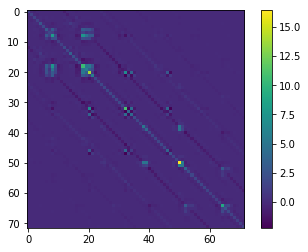

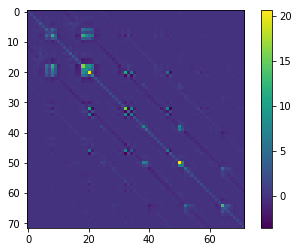

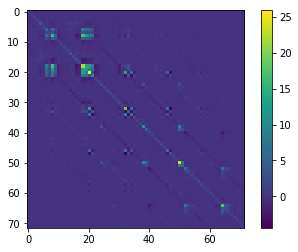

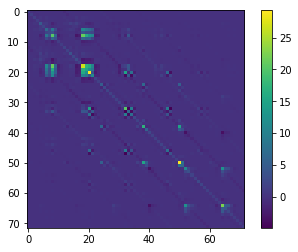

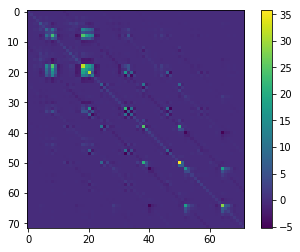

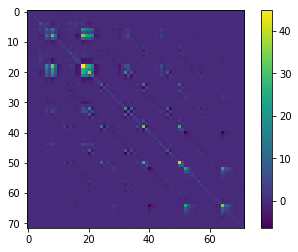

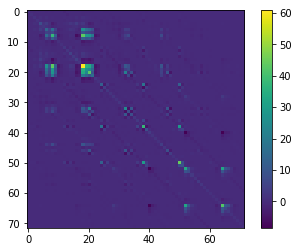

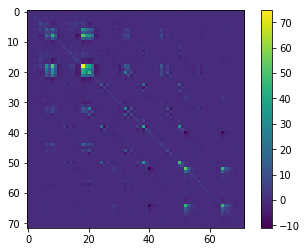

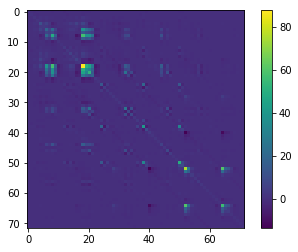

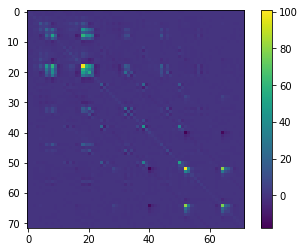

In [62]:
from samplers import MALA, SGLD, MMALA

sampler = MMALA(params, metric_obj=metric, lr=1e-4)
# sampler = MALA(params, lr=3e-4, add_noise=True)
# sampler = SGLD(params, lr0=0.0001, gamma=0.55, t0=100, alpha=0.1)


chain, logp_array = sampler.sample(closure, burn_in=100, num_samples=100)

### Visualization

([array([[ 0.30736698, -0.2048677 ],
       [ 0.09157633, -0.57192595],
       [ 0.03476599,  0.26734468],
       [ 0.22542934,  0.32163803],
       [ 0.84602327, -0.44215789],
       [ 0.0387035 , -0.05282263],
       [ 0.14928055,  0.91267612],
       [ 0.24612002,  1.02134829],
       [ 0.50391774, -0.02559473],
       [-0.11661239,  0.00170711],
       [ 1.40133702, -0.41875759],
       [ 0.25256906,  0.24811304],
       [-0.11209942, -0.10170588],
       [-0.25992915,  1.509309  ],
       [ 0.27853131,  0.33619366],
       [ 0.43717579, -0.76563585],
       [ 0.83981684, -0.85295446],
       [-0.0059136 ,  0.08863354],
       [ 0.21167074, -0.11036357],
       [-0.87053398,  0.409659  ],
       [-0.38832058, -0.05766375],
       [-0.07982508, -0.60077741],
       [-0.1447651 ,  0.14098069],
       [ 0.05755003,  0.41609282],
       [ 0.43186617, -0.24383982],
       [-1.06916839,  0.59106279],
       [-0.23886892, -0.75868898],
       [ 0.1579521 , -0.28570714],
       [ 0.4410231

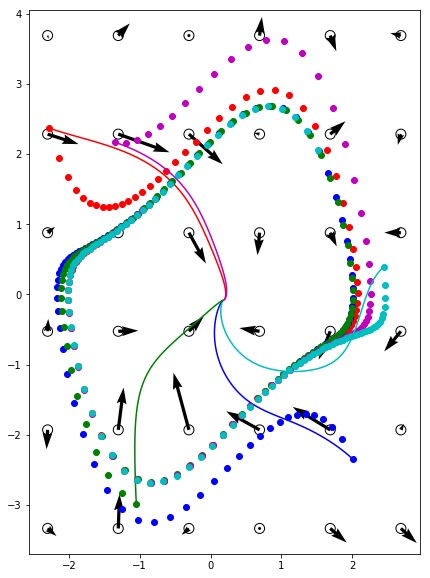

In [56]:
chain = sampler.samples
print(chain[1])
# plotting
mean_U = np.mean([i[0][0] for i in chain if i[1]], axis=0)
# mean_U = chain[499][0][0]
print(mean_U)
kreg.U.data = torch.from_numpy(mean_U)
# mean_logsn = np.mean([i[0][0][1] for i in chain if i[1]], axis=0)
# kreg.logsn.data = torch.from_numpy(mean_logsn)
xode = odeint(kreg, x0, t).detach().numpy()
# U = kreg.U.detach().numpy()
U = mean_U
Z = kreg.Z.detach().numpy()
xode = np.transpose(xode,[1,0,2])

cols = ['r','b','g','m','c','k']
plt.figure(1,[7,10])
plt.scatter(Z[:,0],Z[:,1],100, facecolors='none', edgecolors='k')
plt.quiver(Z[:,0],Z[:,1],U[:,0],U[:,1],units='height',width=0.006,color='k')
for i in range(min(6,xode.shape[0])):
    plt.plot(X[i,:,0],X[i,:,1],'o',color=cols[i])
    plt.plot(xode[i,:,0],xode[i,:,1],'-',color=cols[i])

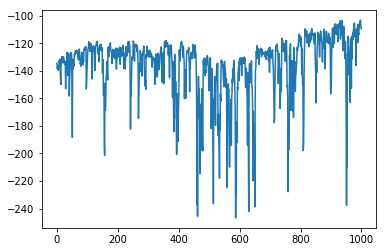

In [65]:
plt.plot(logp_array)

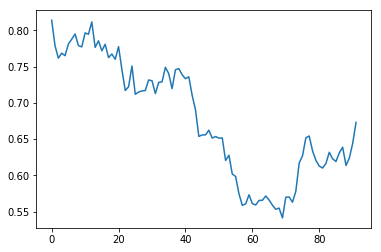

In [61]:
# [sample[0][0][0][0][0] for sample in chain if sample[1]]
plt.plot([sample[0][0][0][10][1] for sample in chain[0:1000:10] if sample[1]])

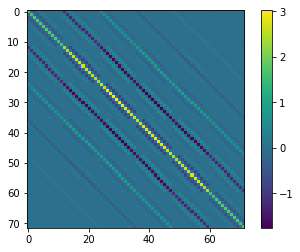

In [77]:
hess = hess_closure()